### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 1 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from numba import njit, prange, NumbaPendingDeprecationWarning
from warnings import filterwarnings

filterwarnings('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
@njit(nogil=True)
def div_samples(x:np.ndarray, y:np.ndarray, feature_id:int, threshold:float):
    """
    Разделяет объекты на 2 множества
    x -- матрица объектов
    y -- вектор ответов
    feature_id -- айдишник признака, по которому делаем сплит
    threshold -- порог, по которому делаем сплит
    """
    left_mask = x[:, feature_id] > threshold
    right_mask = ~left_mask
    return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

@njit(nogil=True)
def div_targets(x:np.ndarray, y:np.ndarray, feature_id:int, threshold:float):
    """
    Разделяет ответы на 2 множества
    x -- матрица объектов
    y -- вектор ответов
    feature_id -- айдишник признака, по которому делаем сплит
    threshold -- порог, по которому делаем сплит
    """
    left_mask = x[:, feature_id] > threshold
    right_mask = ~left_mask
    return y[left_mask], y[right_mask]
    
@njit(nogil=True)
def gini_criterion(cnt, len_):
    if(len_==0): return 1
    return 1 - sum([(c/len_)**2 for c in cnt])
    
@njit(nogil=True)
def entropy_criterion(cnt, len_):
    if(len_==0): return 0
    return -sum([c/len_*np.log(c/len_) for c in cnt])
    
@njit(nogil=True)
def log_loss_criterion(cnt, len_):
    if(len_==0): return 1
    return 1 - cnt.max()/len_

@njit(nogil=True)
def find_threshold_njit(x, y, j, y_criterion, l_mem, r_mem, thresholds, counts):
    l, r = l_mem.copy(), r_mem.copy()
    len_l, len_r = 0, len(y)
    mx_gain, mx_thr = 0, 0
    whole_y = y_criterion(r, len(y))
    # print(whole_y)
            
    for i in range(len(thresholds)):
        threshold, target = thresholds[i]
        target=int(target)
        l[target]+=counts[i]
        r[target]-=counts[i]
        len_l += counts[i]
        len_r -= counts[i]
        if(i!=len(thresholds)-1 and thresholds[i+1][0]==threshold): continue
        gain = -y_criterion(l, len_l)*len_l/len(y) - y_criterion(r, len_r)*len_r/len(y) + whole_y
        # print(threshold, gain, len_l, len_r, l, r, thresholds, counts)
        if(gain>mx_gain):
            mx_gain = gain
            mx_thr = threshold
    return mx_gain, mx_thr

@njit(nogil=True)
def find_threshold_njit_loop(x, y, y_criterion, l_mem, r_mem, uniques):
    mx_gain, mx_j, mx_thr = -1, 0, 0
    for j in range(x.shape[1]):
        thresholds, counts = uniques[j]
        gain, threshold = find_threshold_njit(x, y, j, y_criterion, l_mem, r_mem, thresholds, counts)
        if(gain>mx_gain):
            mx_gain = gain
            mx_j = j
            mx_thr = threshold
    return mx_gain, mx_j, mx_thr

In [3]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = {}
    
    def __gini_criterion(self, cnt, len_):
        if(len_==0): return 1
        return 1 - sum([(c/len_)**2 for c in cnt])
    
    def __entropy_criterion(self, cnt, len_):
        if(len_==0): return 0
        return -sum([c/len_*np.log(c/len_) for c in cnt])
    
    def __log_loss_criterion(self, cnt, len_):
        if(len_==0): return 1
        return 1 - cnt.max()/len_

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        mx_gain, mx_j, mx_thr = -1, 0, 0
        y_criterion = None
        if(self.criterion=='gini'):
            y_criterion = gini_criterion
        elif(self.criterion=='entropy'):
            y_criterion = entropy_criterion
        else:    
            y_criterion = log_loss_criterion
        
        l_mem = np.array([0 for i in range(self.num_class)])
        uniq = np.unique(y)
        r_mem = np.array([sum(y==c) for c in range(self.num_class)])
        
        uniques = [np.unique(list(zip(x[:,j], y)), axis=0, return_counts=True) for j in range(x.shape[1])]
                
        return find_threshold_njit_loop(x, y, y_criterion, l_mem, r_mem, uniques)
                    
            

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if(len(x)==0): return
        self.tree[node_id] = [-1,-1,-1]
        if(depth==self.max_depth or len(x) < self.min_samples_split):
            self.tree[node_id][0] = self.__class__.LEAF_TYPE
            ys, cnt = np.unique(y, return_counts=True)
            ind_max = np.argmax(cnt)
            self.tree[node_id][1] = ys[ind_max]
            self.tree[node_id][2] = cnt[ind_max] / len(y)
            return
        
        self.tree[node_id][0] = self.__class__.NON_LEAF_TYPE
        gain, j, thr = self.__find_threshold(x, y)
        self.feature_importances_[j] += gain
        self.tree[node_id][1] = j
        self.tree[node_id][2] = thr
        if(gain==0): 
            self.tree[node_id][0] = self.__class__.LEAF_TYPE
            ys, cnt = np.unique(y, return_counts=True)
            ind_max = np.argmax(cnt)
            self.tree[node_id][1] = ys[ind_max]
            self.tree[node_id][2] = cnt[ind_max] / len(y)
            return
        
        xl, xr, yl, yr = div_samples(x, y, j, thr)
        
        self.__fit_node(xl, yl, node_id * 2 + 1, depth+1)
        self.__fit_node(xr, yr, node_id * 2 + 2, depth+1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = [0 for i in range(x.shape[1])]
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def __predict_proba(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_proba(x, 2 * node_id + 1)
            else:
                return self.__predict_proba(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict_proba(self, X):
        """
        Вызывает predict_proba для всех объектов из матрицы X
        """
        return np.array([self.__predict_proba(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return np.array(self.feature_importances_)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


In [23]:
my_clf = MyDecisionTreeClassifier(min_samples_split=3, criterion='entropy')
clf = DecisionTreeClassifier(min_samples_split=3, criterion='entropy')
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7361282367447596
0.8199753390875463


In [9]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='log_loss')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='log_loss')
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.8333333333333334


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [10]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: [0, 1, 2], 1: [1, 1, 0.7142857142857143], 2: [1, 0, 1.0]} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: [0, 1, 2], 1: [0, 1, 6], 3: [1, 1, 1.0], 4: [1, 0, 0.5], 2: [1, 0, 1.0]} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: [0, 1, 2], 1: [0, 1, 6], 3: [1, 1, 1.0], 4: [0, 1, 4], 9: [1, 0, 1.0], 10: [1, 1, 1.0], 2: [1, 0, 1.0]} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: [0, 1, 2], 1: [0, 1, 6], 3: [1, 1, 1.0], 4: [0, 1, 4], 9: [1, 0, 1.0], 10: [1, 1, 1.0], 2: [1, 0, 1.0]} [0 0 0 0 0 1 1 1 1 1]


### Придумайте интересные примеры для отладки дерева решений (доп. задание)
Это необязательный пункт. За него можно получить 1 доп балл. 
Можете придумать примеры для отладки дерева, похожие на пример выше. 

Они должны быть не сложные, но в то же время информативные, чтобы можно было понять, что реализация содержит ошибки.
Вместе с примером нужно указать ожидаемый выход модели. 

In [11]:
# Примеры

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [12]:
%%timeit -n 10 -r 10 
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5)
clf.fit(X_train, y_train)

The slowest run took 4.26 times longer than the fastest. This could mean that an intermediate result is being cached.
2.9 ms ± 1.59 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [13]:
%%timeit -n 10 -r 10 
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5)
my_clf.fit(X_train, y_train)

69.4 ms ± 5.82 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [14]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [15]:
df = pd.read_csv('Speed_Dating_Data.csv', encoding='latin1')
df = preprocess_spd_data(df)
df

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8374,552,1,527.0,0,0.71,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8375,552,1,528.0,0,-0.46,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8376,552,1,529.0,0,0.62,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0


In [16]:
df_X,df_y = df.drop(['match'], axis=1, inplace=False), df.match
X,y = df_X.to_numpy(), df_y.to_numpy()

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)

In [18]:
model = MyDecisionTreeClassifier(min_samples_split=20, max_depth=20, criterion='entropy')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
print(f"ROC-AUC score:{roc_auc_score(y_test, 1-y_pred)}")

ROC-AUC score:0.6072664538057472


In [19]:
model = MyDecisionTreeClassifier(min_samples_split=20, max_depth=20, criterion='gini')
model.fit(X_train, y_train)
print('gini', accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
model = MyDecisionTreeClassifier(min_samples_split=20, max_depth=20, criterion='entropy')
model.fit(X_train, y_train)
print('entropy', accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
model = MyDecisionTreeClassifier(min_samples_split=20, max_depth=20, criterion='log_loss')
model.fit(X_train, y_train)
print('log_loss', accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

gini 0.7718865598027127
entropy 0.7928483353884094
log_loss 0.8187422934648582


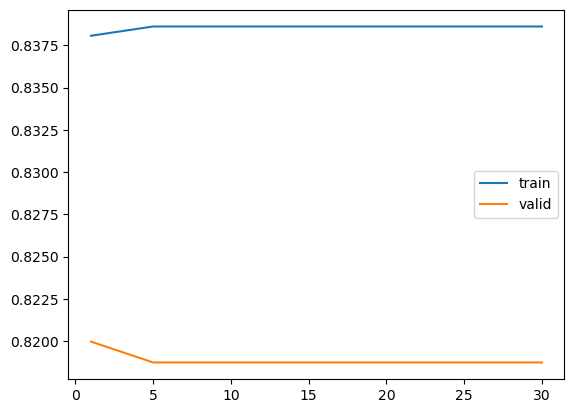

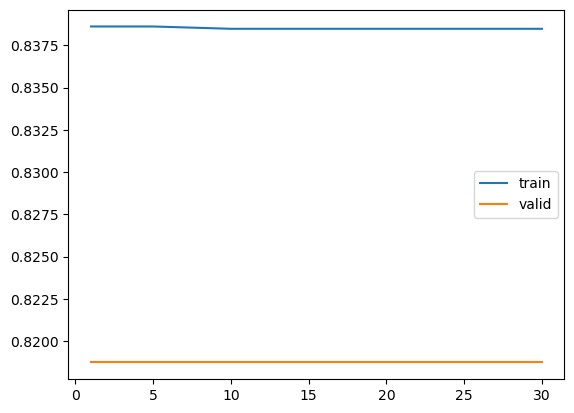

In [20]:
score_train=[]
score_valid=[]
params=[1,5,10,20,30]
for n in params:
    model = MyDecisionTreeClassifier(min_samples_split=2, max_depth=n, criterion='log_loss')
    model.fit(X_train, y_train)
    score_train.append(accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    score_valid.append(accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
plt.plot(params, score_train, label='train')
plt.plot(params, score_valid, label='valid')
plt.legend()
plt.show()

score_train=[]
score_valid=[]
params=[1,5,10,20,30]
for n in params:
    model = MyDecisionTreeClassifier(min_samples_split=n, max_depth=5, criterion='log_loss')
    model.fit(X_train, y_train)
    score_train.append(accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    score_valid.append(accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
plt.plot(params, score_train, label='train')
plt.plot(params, score_valid, label='valid')
plt.legend()
plt.show()

In [21]:
max(*score_train, *score_valid)

0.8386123680241327

Максимальная достигнутая точность на валидации - 83.90%. Наилучший критерий информативности, подобранный на валидации - критерий log_loss

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

Судя по валидации, при увеличении глубины деревья действительно переобучаются. Качество на тренировочном датасете растёт, а на валидационном - падает

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [22]:
model = MyDecisionTreeClassifier(min_samples_split=20, max_depth=20, criterion='log_loss')
model.fit(X_train, y_train)
[df_X.columns[j] for j in model.get_feature_importance().argsort()][:10]

['attr1_1',
 'fun3_1',
 'sinc3_1',
 'attr3_1',
 'shar2_1',
 'amb2_1',
 'fun2_1',
 'intel2_1',
 'sinc2_1',
 'attr2_1']

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?
Самое непонятное - как реализовать быстрый fit. Я, вроде, свёл время к O(N\*log(N)) когда различных значений признака немного, и O(N^2) в худшем случае, и всё равно медленно. Не очень понятно, что ещё можно оптимизировать, если проводить полный перебор по признакам и порогам

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

